### Developing infrastructure for calculating rolling correlations over diff periods of time for combinations of asset pairs: (asset 1, asset 2, corr_window, business_date)

In [4]:
import os
import sys

import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
from typing import Optional, Set

# Required to import other modules from this project, in folders such as utils/ or notebooks/
current_folder = os.getcwd()
project_root_folder = os.path.abspath(os.path.join(current_folder, ".."))
sys.path.append(project_root_folder)
# Import functionalities from other modules in this project
from utils.db_utils import *

# Load .env file for AWS RDS login credentials
from dotenv import load_dotenv
dotenv_path = os.path.join(project_root_folder, ".env")
load_dotenv(dotenv_path)

# Global variables
conn, cursor = connect_to_rds()

✅ Connected successfully!


### Generate unique pairs of assets. I might not need all of these, though

In [2]:
dates_query = """
select ticker from tbl_active_tickers
where is_active = TRUE;
"""

df_active_tickers = sql_query_as_df(dates_query, cursor)

In [3]:
# Dataframe -> series -> np array -> list
active_tickers = df_active_tickers["ticker"].values.tolist()

In [5]:
from itertools import combinations

In [ ]:
# Get all unique combinations of (asset_1, asset_2) pairs
asset_pairs_unsorted = list(combinations(active_tickers, 2))
asset_pairs_sorted = [tuple(sorted((asset_1, asset_2))) for (asset_1, asset_2) in asset_pairs_unsorted]
asset_pairs_sorted

[('GLD', 'SPY'),
 ('NVDA', 'SPY'),
 ('SPY', 'TSLA'),
 ('SPY', 'TLT'),
 ('SLV', 'SPY'),
 ('GLD', 'NVDA'),
 ('GLD', 'TSLA'),
 ('GLD', 'TLT'),
 ('GLD', 'SLV'),
 ('NVDA', 'TSLA'),
 ('NVDA', 'TLT'),
 ('NVDA', 'SLV'),
 ('TLT', 'TSLA'),
 ('SLV', 'TSLA'),
 ('SLV', 'TLT')]

### Function to calculate rolling correlation given (asset 1, asset 2, roll_corr_window, business_date). Default business_date should be most recent business_date.  Should rolling correlation window be passed in as "1M", "3M", and "6M"?

In [22]:
def get_intersection_of_business_dates_for_asset_pair(asset_1: str, asset_2: str, cursor: Cursor) -> Set[date]:
    """
    Given a pair of (asset_1, asset_2), return the set of business_date for which price/volume data is available for both (intersection of valid business_date for these 2 assets).  For example, if TSLA has price/volume on (date_1, date_2, date_3) and NVDA has price/volume on (date_2, date_3, date_4), this will return a set of dates (date_2, date_3) only
    """

    dates_query = f"""
    (
        select business_date
        from tbl_daily_prod
        where ticker = '{asset_1}'
    )
    intersect
    (
        select business_date
        from tbl_daily_prod
        where ticker = '{asset_2}'
    )
    order by business_date;
    """

    df_business_dates = sql_query_as_df(dates_query, cursor)

    business_dates_common_to_both_assets = set(pd.to_datetime(df_business_dates["business_date"]))

    if not business_dates_common_to_both_assets:
        raise ValueError(f"No business dates in common between {asset_1} and {asset_2}")
    
    return business_dates_common_to_both_assets

In [23]:
def convert_business_date_from_str_to_date_or_none(user_input_business_date_str: Optional[str]) -> Optional[date]:
    """
    Attempt to convert an input from user from string into date.  Needs to be in YYYY-MM-DD or other acceptable format.  Can also be None, in which case, we will handle no user input by getting set of valid business_date downstream
    """
    
    if user_input_business_date_str:
        try:
            user_input_business_date = pd.to_datetime(user_input_business_date_str)
        except ValueError:
            print(f"Error: User's input {user_input_business_date_str} cannot be converted into a valid date. Needs to be YYYY-MM-DD format")            
            sys.exit(1)
    else:
        user_input_business_date = None

    return user_input_business_date

In [24]:
def get_end_date_for_asset_pair(user_input_business_date: Optional[date], business_dates_common_to_both_assets: Set[date]) -> date:
    """
    Given an user input date, which could be none (not provided), and a set of valid business_date between both assets, get the end_date of the rolling correlation calculation.  If user does not provide an end_date, or the end_date provided by the user is not among the set of valid business_date between these 2 assets, return the max business_date instead. For example, if (asset_1, asset_2) both have price/volume on (date_1, date_2), and user gives date_3 or None, this method will return end_date = date_2
    """

    if (user_input_business_date is None) or (user_input_business_date not in business_dates_common_to_both_assets):
        end_date = max(business_dates_common_to_both_assets)
        print(f"User did not provide business_date or provided date not in business_dates of database, so defaulting to max(business_dates_common_to_both_assets): {end_date}")
    else:
        end_date = user_input_business_date
    
    return end_date

In [25]:
def get_start_date_for_asset_pair(end_date: date, roll_corr_window: str, business_dates_common_to_both_assets: Set[date]) -> date:
    """
    Get n months before end_date. Get the max business_date that is less than or equal to n_months_before_end_date, and set that as start_date (in case n_months_before_end_date isn't in business_dates_common_to_both_assets)
    """

    # TODO: If time permits, I should be able to parse strings such as "12M" or "1Y" into integers automatically, instead of relying on a static mapping (where I would have to list out potentially infinite combinations)
    # Convert user input (str) into integer number of months
    roll_corr_window_map = {"1M": 1, "3M": 3, "6M": 6, "12M": 12, "1Y": 12}

    # Needs to be one of these keys, such as "1M", "3M", etc.
    if roll_corr_window not in roll_corr_window_map:
        valid_keys = list(roll_corr_window_map.keys())
        raise ValueError(f"User input {roll_corr_window} is not a valid input. Needs to be among: {valid_keys}")
    n_months = roll_corr_window_map[roll_corr_window]

    # Get n months before the end_date, and try to find the closest date among business_dates_common_to_both_assets, and set that to start_date
    n_months_before_end_date = end_date - relativedelta(months = n_months)
    if n_months_before_end_date < min(business_dates_common_to_both_assets):
        raise ValueError(f"Database doesn't have enough historical returns data to calculate {roll_corr_window} of correlation")
    start_date = max([d for d in business_dates_common_to_both_assets if d <= n_months_before_end_date])

    return start_date

In [ ]:
def get_asset_1_and_asset_2_returns_and_calc_corr(asset_1: str, asset_2: str, start_date: date, end_date: date, cursor: Cursor) -> float:
    """
    Access prod table tbl_daily_prod, to get returns of asset_1 and asset_2 between start_date and end_date. Then calculate the correlation
    """

    returns_query = f"""
    select
        asset_1.adj_close_pct_chg as asset_1_returns,
        asset_2.adj_close_pct_chg as asset_2_returns
    from tbl_daily_prod asset_1 join tbl_daily_prod asset_2
        on asset_1.business_date = asset_2.business_date
    where
        asset_1.ticker = '{asset_1}' and asset_1.business_date between '{start_date}' and '{end_date}'
        and asset_2.ticker = '{asset_2}' and asset_2.business_date between '{start_date}' and '{end_date}'
    order by asset_1.business_date;
    """
    df_returns = sql_query_as_df(returns_query, cursor)

    asset_1_2_corr = df_returns["asset_1_returns"].corr(df_returns["asset_2_returns"])

    return asset_1_2_corr

In [ ]:
def calc_return_correlation(asset_1: str, asset_2: str, roll_corr_window: str, cursor: Cursor, user_input_business_date_str: Optional[str] = None):
    """
    Calculate the correlation of daily returns between asset_1 and asset_2 over a window of time. Optionally pass in the end_date; if none is provided, function will retrieve the latest business_date shared between the two assets
    Example: asset_1 = "SPY", asset_2 = "TLT", roll_corr_window = "3M" calculates the 3 month correlation between SPY & TLT between 3 months ago to the latest business_date
    Example: asset_1 = "SPY", asset_2 = "GLD", roll_corr_window = "6M", user_input_business_date_str = "2025-06-01" calculates the 6 month correlation between SPY & GLD during the period between 2025-06-01 and 6 months prior
    """

    # Get the set of valid business_date common to both asset_1 and asset_2
    business_dates_common_to_both_assets = get_intersection_of_business_dates_for_asset_pair(asset_1, asset_2, cursor)

    # Attempt to convert user's input of business_date from string into date
    user_input_business_date = convert_business_date_from_str_to_date_or_none(user_input_business_date_str)

    # Get the latest possible common business_date between asset_1 and asset_2
    end_date = get_end_date_for_asset_pair(user_input_business_date, business_dates_common_to_both_assets)

    # Get n months before end_date. Get the max business_date that is less than or equal to n_months_before_end_date, and set that as start_date (in case n_months_before_end_date isn't in business_dates_common_to_both_assets)
    start_date = get_start_date_for_asset_pair(end_date, roll_corr_window, business_dates_common_to_both_assets)

    # Get both series of daily returns from asset_1 and asset_2 between start_date and end_date, and calculate the correlation
    asset_1_2_corr = get_asset_1_and_asset_2_returns_and_calc_corr(asset_1, asset_2, start_date, end_date, cursor)

    return asset_1_2_corr

In [ ]:
# Example 1
asset_1 = "TSLA"
asset_2 = "SPY"
roll_corr_window = "3M"
calc_return_correlation(asset_1, asset_2, roll_corr_window, cursor)

User did not provide business_date or provided date not in business_dates of database, so defaulting to max(business_dates_common_to_both_assets): 2025-06-20 00:00:00


np.float64(0.7909642739810769)

In [36]:
# Example 2
asset_1 = "GLD"
asset_2 = "SPY"
roll_corr_window = "1M"
user_input_business_date_str = "2025-06-03"
calc_return_correlation(asset_1, asset_2, roll_corr_window, cursor, user_input_business_date_str)

np.float64(-0.5783829029460327)

### Create a loop over calc_return_correlation to get a time series of rolling correlations

In [12]:
def convert_corr_window_from_str_to_months(roll_corr_window: str) -> int:
    """
    Convert strings such as "3M" or "1Y" into number of months, such as 3 or 12
    """
    # TODO: If time permits, I should be able to parse strings such as "12M" or "1Y" into integers automatically, instead of relying on a static mapping (where I would have to list out potentially infinite combinations)
    # Convert user input (str) into integer number of months
    roll_corr_window_map = {"1M": 1, "3M": 3, "6M": 6, "12M": 12, "1Y": 12, "2Y": 24}

    # Needs to be one of these keys, such as "1M", "3M", etc.
    if roll_corr_window not in roll_corr_window_map:
        valid_keys = list(roll_corr_window_map.keys())
        raise ValueError(f"User input {roll_corr_window} is not a valid input for rolling window. Needs to be among: {valid_keys}")
    n_months = roll_corr_window_map[roll_corr_window]

    return n_months

In [13]:
def convert_business_date_from_str_to_date_or_none(user_input_business_date_str: Optional[str]) -> Optional[date]:
    """
    Attempt to convert an input from user from string into date.  Needs to be in YYYY-MM-DD or other acceptable format.  Can also be None, in which case, we will handle no user input by getting set of valid business_date downstream
    """
    
    if user_input_business_date_str:
        try:
            user_input_business_date = pd.to_datetime(user_input_business_date_str)
        except ValueError:
            raise ValueError(f"Error: User's input {user_input_business_date_str} cannot be converted into a valid date. Needs to be YYYY-MM-DD format")            
    else:
        user_input_business_date = None

    return user_input_business_date

In [14]:
def get_intersection_of_business_dates_for_asset_pair(asset_1: str, asset_2: str, cursor: Cursor) -> Set[date]:
    """
    Given a pair of (asset_1, asset_2), return the set of business_date for which price/volume data is available for both (intersection of valid business_date for these 2 assets).  For example, if TSLA has price/volume on (date_1, date_2, date_3) and NVDA has price/volume on (date_2, date_3, date_4), this will return a set of dates (date_2, date_3) only
    """

    dates_query = f"""
    (
        select business_date
        from tbl_daily_prod
        where ticker = '{asset_1}'
    )
    intersect
    (
        select business_date
        from tbl_daily_prod
        where ticker = '{asset_2}'
    )
    order by business_date;
    """

    df_business_dates = sql_query_as_df(dates_query, cursor)

    business_dates_common_to_both_assets = set(pd.to_datetime(df_business_dates["business_date"]))

    if not business_dates_common_to_both_assets:
        raise ValueError(f"No business dates in common between {asset_1} and {asset_2}")
    
    return business_dates_common_to_both_assets

In [15]:
def get_min_start_date_for_asset_pair(business_dates_common_to_both_assets: Set[date], n_months: int):
    """
    Given a given set of business dates, get the minimum date that is n_months more than the min business_date
    """
    min_business_date = min(business_dates_common_to_both_assets)
    max_business_date = max(business_dates_common_to_both_assets)
    n_months_after_min_business_date = min_business_date + relativedelta(months = n_months)
    if n_months_after_min_business_date > max_business_date:
        raise ValueError(f"Database doesn't have enough historical returns data to calculate {n_months} months of correlation")
    min_start_date = min([d for d in business_dates_common_to_both_assets if d >= n_months_after_min_business_date])

    return min_start_date   

In [16]:
def get_end_date_for_asset_pair(user_input_business_date: Optional[date], business_dates_common_to_both_assets: Set[date]) -> date:
    """
    Given an user input date, which could be none (not provided), and a set of valid business_date between both assets, get the end_date of the rolling correlation calculation.  If user does not provide an end_date, or the end_date provided by the user is not among the set of valid business_date between these 2 assets, return the max business_date instead. For example, if (asset_1, asset_2) both have price/volume on (date_1, date_2), and user gives date_3 or None, this method will return end_date = date_2
    """

    if (user_input_business_date is None) or (user_input_business_date not in business_dates_common_to_both_assets):
        end_date = max(business_dates_common_to_both_assets)
        print(f"User did not provide business_date or provided date not in business_dates of database, so defaulting to max(business_dates_common_to_both_assets): {end_date}")
    else:
        end_date = user_input_business_date
    
    return end_date

In [17]:
def get_start_date_for_asset_pair(end_date: date, n_months: int, business_dates_common_to_both_assets: Set[date]) -> date:
    """
    Get n months before end_date. Get the max business_date that is less than or equal to n_months_before_end_date, and set that as start_date (in case n_months_before_end_date isn't in business_dates_common_to_both_assets)
    """

    # Get n months before the end_date, and try to find the closest date among business_dates_common_to_both_assets, and set that to start_date
    n_months_before_end_date = end_date - relativedelta(months = n_months)
    if n_months_before_end_date < min(business_dates_common_to_both_assets):
        raise ValueError(f"Database doesn't have enough historical returns data to calculate {n_months} months of correlation")
    start_date = max([d for d in business_dates_common_to_both_assets if d <= n_months_before_end_date])

    return start_date

In [22]:
def get_asset_1_and_asset_2_returns_and_calc_corr(asset_1: str, asset_2: str, start_date: date, end_date: date, cursor: Cursor) -> float:
    """
    Access prod table tbl_daily_prod, to get returns of asset_1 and asset_2 between start_date and end_date. Then calculate the correlation
    """

    returns_query = f"""
    select
        asset_1.adj_close_pct_chg as asset_1_returns,
        asset_2.adj_close_pct_chg as asset_2_returns
    from tbl_daily_prod asset_1 join tbl_daily_prod asset_2
        on asset_1.business_date = asset_2.business_date
    where
        asset_1.ticker = '{asset_1}' and asset_1.business_date between '{start_date}' and '{end_date}'
        and asset_2.ticker = '{asset_2}' and asset_2.business_date between '{start_date}' and '{end_date}'
    order by asset_1.business_date;
    """
    df_returns = sql_query_as_df(returns_query, cursor)

    asset_1_2_corr = df_returns["asset_1_returns"].corr(df_returns["asset_2_returns"])

    return asset_1_2_corr

In [18]:
def calc_return_correlation(asset_1: str, asset_2: str, business_dates_common_to_both_assets: Set[date], roll_corr_window: str, cursor: Cursor, end_date: date):
    """
    Calculate the correlation of daily returns between asset_1 and asset_2 over a window of time. Optionally pass in the end_date; if none is provided, function will retrieve the latest business_date shared between the two assets
    Example: asset_1 = "SPY", asset_2 = "TLT", roll_corr_window = "3M" calculates the 3 month correlation between SPY & TLT between 3 months ago to the latest business_date
    Example: asset_1 = "SPY", asset_2 = "GLD", roll_corr_window = "6M", user_input_business_date_str = "2025-06-01" calculates the 6 month correlation between SPY & GLD during the period between 2025-06-01 and 6 months prior
    """
    n_months = convert_corr_window_from_str_to_months(roll_corr_window)

    # Get n months before end_date. Get the max business_date that is less than or equal to n_months_before_end_date, and set that as start_date (in case n_months_before_end_date isn't in business_dates_common_to_both_assets)
    start_date = get_start_date_for_asset_pair(end_date, n_months, business_dates_common_to_both_assets)

    # Get both series of daily returns from asset_1 and asset_2 between start_date and end_date, and calculate the correlation
    asset_1_2_corr = get_asset_1_and_asset_2_returns_and_calc_corr(asset_1, asset_2, start_date, end_date, cursor)

    return asset_1_2_corr

In [19]:
def calc_rolling_return_correlation(asset_1: str, asset_2: str, roll_corr_window: str, cursor: Cursor, user_input_business_date_str: Optional[str] = None):

    try:
        n_months = convert_corr_window_from_str_to_months(roll_corr_window)
        user_input_business_date = convert_business_date_from_str_to_date_or_none(user_input_business_date_str) 
    except ValueError as e:
        print(f"Unable to parse user input: {e}")
        sys.exit(1)   

    try:
        business_dates_common_to_both_assets = get_intersection_of_business_dates_for_asset_pair(asset_1, asset_2, cursor)
        min_end_date = get_min_start_date_for_asset_pair(business_dates_common_to_both_assets, n_months)
        max_end_date = get_end_date_for_asset_pair(user_input_business_date, business_dates_common_to_both_assets)
    except ValueError as e:
        print(f"Failure encountered in date math calculations: {e}")
        sys.exit(1)

    sorted_business_dates = sorted(business_dates_common_to_both_assets)
    end_dates = [end_date for end_date in sorted_business_dates if min_end_date <= end_date <= max_end_date]
    correlation_rows = []

    # Loop within business_dates_common_to_both_assets, from min_end_date and max_end_date
    for end_date in end_dates:
        try:
            corr = calc_return_correlation(asset_1, asset_2, business_dates_common_to_both_assets, roll_corr_window, cursor, end_date)
            row_corr = {
                "asset_1": asset_1,
                "asset_2": asset_2,
                "roll_corr_window": roll_corr_window,
                "end_date": end_date,
                "correlation": corr
            }
            correlation_rows.append(row_corr)
        except Exception as e:
            print(f"Skipping date {end_date} due to error: {e}")
            continue
    
    df_corr = pd.DataFrame(correlation_rows)

    return df_corr    

In [27]:
import matplotlib.pyplot as plt

def plot_rolling_correlation(df_corr: pd.DataFrame):
    """
    Given a DataFrame with columns ['asset_1', 'asset_2', 'roll_corr_window', 'end_date', 'correlation'],
    this function creates a time series plot of the rolling correlation.
    """
    if df_corr.empty:
        print("DataFrame is empty. Nothing to plot.")
        return

    # Extract metadata for plot title
    asset_1 = df_corr['asset_1'].iloc[0]
    asset_2 = df_corr['asset_2'].iloc[0]
    roll_corr_window = df_corr['roll_corr_window'].iloc[0]

    # Sort by date in case it isn't sorted
    df_corr_sorted = df_corr.sort_values(by="end_date")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_corr_sorted["end_date"], df_corr_sorted["correlation"], marker="o", linestyle="-")
    plt.title(f"Rolling {roll_corr_window} Correlation between {asset_1} and {asset_2}")
    plt.xlabel("End Date")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
# Test it out now
nvda_tsla_correlation = calc_rolling_return_correlation(
    asset_1 = "NVDA",
    asset_2 = "TSLA",
    roll_corr_window = "3M",
    cursor = cursor
)

User did not provide business_date or provided date not in business_dates of database, so defaulting to max(business_dates_common_to_both_assets): 2025-06-20 00:00:00


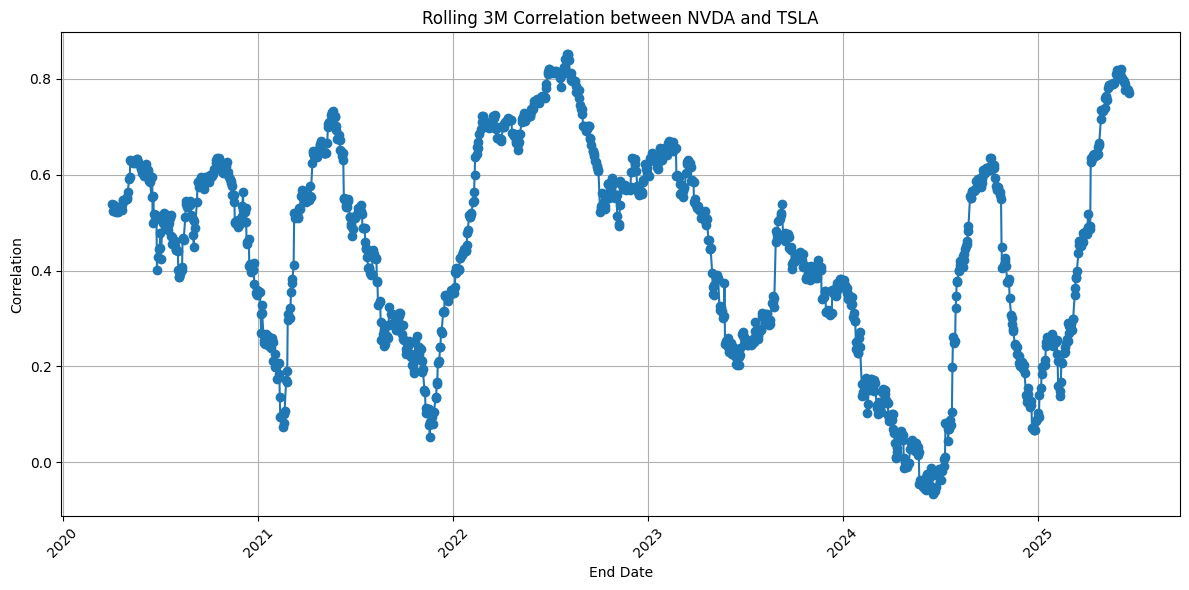

In [28]:
# Should I plot this?
plot_rolling_correlation(nvda_tsla_correlation)

In [29]:
# TODO: Then we need to write this to a SQL table with these 5 columns, keyed on (asset_1, asset_2, roll_corr_window, end_date), mapping to a correlation